# Машинное обучение, ФКН ВШЭ

## Практическое задание 4. Классификация

### Общая информация
Дата выдачи: 09.11.2023

Мягкий дедлайн: 22.11.2023

Жесткий дедлайн: 26.11.2023

### О задании

В этом задании вы:
- ознакомитесь с тем, что происходит "внутри" метода опорных векторов и логистической регрессии
- познакомитесь с калибровкой вероятности
- изучите методы трансформации переменных и методы отбора признаков
- попробуете оценить экономический эффект модели

----

#### Самостоятельная оценка результатов

Для удобства проверки, исходя из набора решенных задач, посчитайте свою максимальную оценку.

**Оценка**: 10

### Оценивание и штрафы

Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

Сдавать задание после указанного жёсткого дедлайна нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

### Формат сдачи

Для сдачи задания переименуйте получившийся файл *.ipynb в соответствии со следующим форматом: homework-practice-04-linclass-__Username__.ipynb, где Username — ваша фамилия и имя на латинице именно в таком порядке (например, homework-practice-04-linclass-__IvanovIvan__.ipynb).

# Часть 1. SVM, LR и калибровка вероятностей (2 балла + 0.5 бонус)

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

#### __Задание 1.1  Сравнение методов__ (0.5 балла)



Сгенерируем синтетические данные.

In [8]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

# фиксируем random_state для воспроизводимости результатов
X, y = make_classification(
    n_samples=10000, n_features=10, n_informative=5, n_redundant=5, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

/Users/olegchernikov/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


__Случайный классификатор__

Для начала зададим самую простую модель, которая на каждом объекте выдаёт случайный ответ. По тестовой выборке вычислим AUC-ROC, AUC-PR.

In [9]:
from sklearn.dummy import DummyClassifier
random_classifier = DummyClassifier(strategy='uniform', random_state=42).fit(X_train, y_train)
y_random = random_classifier.predict_proba(X_test)[:,1]
y_random

array([0.5, 0.5, 0.5, ..., 0.5, 0.5, 0.5])

In [10]:
# from sklearn.metrics import roc_auc_score
# from sklearn.metrics import precision_recall_curve
# from sklearn.metrics import roc_curve
# from sklearn.metrics import auc
# from sklearn.metrics import average_precision_score

In [11]:
# precision, recall, thresholds = precision_recall_curve(y_test, y_random)
# auc_pr = auc(recall, precision)
# print(f'AUC-PR: {auc_pr}')
# plt.plot(recall, precision)
# plt.xlabel('recall')
# plt.ylabel('precision')
# plt.show()

In [12]:
# fpr, tpr, thresholds = metrics.roc_curve(y_test, y_random)
# roc_auc = roc_auc_score(y_test, y_random)
# print(f'AUC-ROC: {roc_auc}')
# plt.plot(fpr, tpr)
# plt.xlabel('FPR')
# plt.ylabel('TPR')
# plt.show()

**Вопрос:** решаем задачу бинарной классификации, но y\_random содержит какие-то дробные числа, а не 0/1. Почему?



**Ответ**: Потому что это вероятности.

*Ниже приведен **пример** работы* со встроенными функциями `sklearn` для отрисовки ROC и PR кривых, сохранения метрик. Пайплайн можно изменять как вам удобно.

In [13]:
from sklearn.metrics import auc
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay

from sklearn.metrics import roc_auc_score
from sklearn.metrics import RocCurveDisplay

Random Classifier metrics
AUC-PR: 0.75283
AUC-ROC: 0.50000


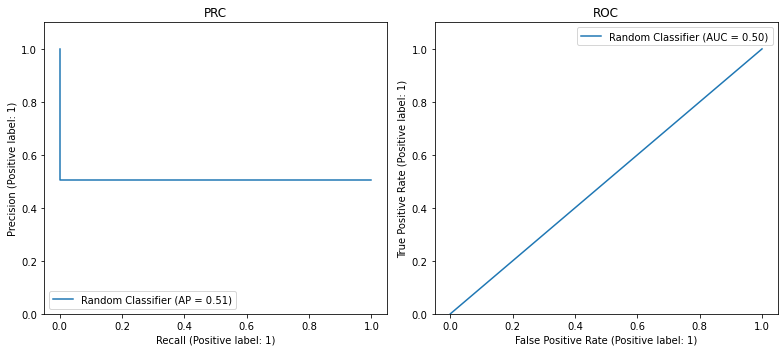

In [14]:
def depict_pr_roc(y_true, y_pred, classifier_name='Some Classifier', ax=None):
  if ax is None:
    fig, ax = plt.subplots(1, 2, figsize=(11, 5))

  print(classifier_name, 'metrics')
  PrecisionRecallDisplay.from_predictions(y_true, y_pred, ax=ax[0], name=classifier_name)
  precision, recall, _ = precision_recall_curve(y_true, y_pred)
  print('AUC-PR: %.5f' % auc(recall, precision))
  ax[0].set_title("PRC")
  ax[0].set_ylim(0, 1.1)

  RocCurveDisplay.from_predictions(y_true, y_pred, ax=ax[1], name=classifier_name)
  print('AUC-ROC: %.5f' % roc_auc_score(y_true, y_pred))
  ax[1].set_title("ROC")
  ax[1].set_ylim(0, 1.1)

  plt.tight_layout()
  plt.legend()


depict_pr_roc(y_test, y_random, 'Random Classifier')

In [15]:
# dataframe для сравнения
# методов классификации по метрикам
df_metrics = pd.DataFrame(columns=['AUC_PR', 'AUC_ROC', 'reg_const'])
precision, recall, _ = precision_recall_curve(y_test, y_random)
  # добавление очередной строки с характеристиками метода
df_metrics.loc['Random Classifier'] = [
      auc(recall, precision),
      roc_auc_score(y_test, y_random),
      0
]

  # по аналогии результаты следующих экспериментов можно будет собрать в табличку
df_metrics

,AUC_PR,AUC_ROC,reg_const
Random Classifier,0.752833,0.5,0.0


__Support Vector Machine (Linear Kernel)__

Обучите метод опорных векторов.

На занятиях мы проходили линейный вариант без ядрового перехода, что соответствует линейному ядру (`LinearSVC` или же `SVC(kernel='linear')` в `sklearn.svm`).

Подберите параметр регуляризации `C` с точки зрения AUC-PR (можете воспользоваться кросс-валидацией или отделить валидационную выборку от обучающей).


In [16]:
# # Делим тестовую выборку на тестовую-тестовую и валидационную:
# X_test_test, X_val, y_test_test, y_val = train_test_split(X_test, y_test, test_size=0.3, random_state=42)

In [17]:
import warnings
warnings.filterwarnings('ignore')

from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV

np.random.seed(1)

svc = LinearSVC()

C_list = [0.0001, 0.001, 0.01, 0.1, 1, 5, 10, 100, 1000]
params = dict(C=C_list)

svc_solver = GridSearchCV(svc,
                         params,
                         scoring='average_precision',
                         cv = 4)

svc_solver.fit(X_train, y_train)

best_svc_C = svc_solver.best_params_['C']

In [18]:
best_svc_C

0.0001

In [19]:
SVC = LinearSVC(C=best_svc_C, random_state=1)
SVC.fit(X_train, y_train)

y_svc = SVC.predict(X_test)

  На тестовой части:
  - постройте ROC и PR кривые,
  - посчитайте AUC-ROC, AUC-PR с точностью до 5 знаков

SVC Classifier metrics
AUC-PR: 0.82850
AUC-ROC: 0.76578


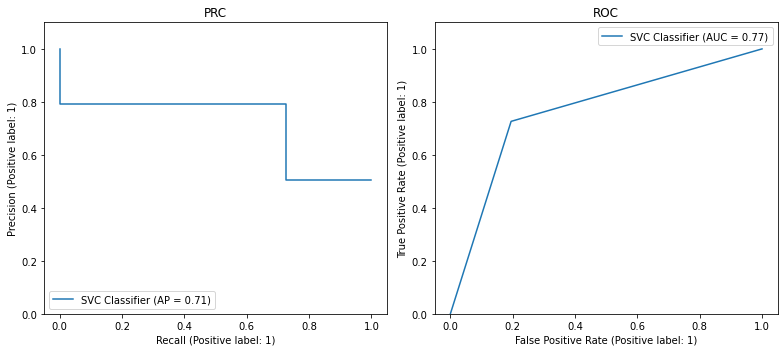

In [20]:
depict_pr_roc(y_test, y_svc, 'SVC Classifier')

Сравните AUC-ROC и AUC-PR для вашей модели с этими же метриками для случайного классификатора.

In [21]:
precision, recall, _ = precision_recall_curve(y_test, y_svc)
  # добавление очередной строки с характеристиками метода
df_metrics.loc['SVC Classifier'] = [
      auc(recall, precision),
      roc_auc_score(y_test, y_svc),
      best_svc_C
]

  # по аналогии результаты следующих экспериментов можно будет собрать в табличку
df_metrics

,AUC_PR,AUC_ROC,reg_const
Random Classifier,0.752833,0.500000,0.0000
SVC Classifier,0.828501,0.765779,0.0001


In [22]:
auc_pr_diff = df_metrics.loc['SVC Classifier']['AUC_PR'] - df_metrics.loc['Random Classifier']['AUC_PR']
auc_roc_diff = df_metrics.loc['SVC Classifier']['AUC_ROC'] - df_metrics.loc['Random Classifier']['AUC_ROC']

print(f'auc-pr вырос на: {auc_pr_diff}')
print(f'auc-roc вырос на: {auc_roc_diff}')

auc-pr вырос на: 0.07566810953612879
auc-roc вырос на: 0.2657792489790911


__Logistic Regression__


Аналогичное задание для логистической регрессии с L2 регуляризатором:


*   подберите гиперпараметр C, используя метрику AUC-PR
*   нарисуйте ROC, PR кривые для тестовой части
*   выведите метрики для тестовых данных и сравните их с результатами случайного классификатора



In [23]:
import warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

np.random.seed(1)

logreg = LogisticRegression(penalty='l2')

C_list = [0.0001, 0.001, 0.01, 0.1, 1, 5, 10, 100, 1000]
params = dict(C=C_list)

logreg_solver = GridSearchCV(logreg,
                         params,
                         scoring='average_precision',
                         cv = 4)

logreg_solver.fit(X_train, y_train)

best_logreg_C = logreg_solver.best_params_['C']

In [24]:
best_logreg_C

0.001

In [25]:
LogReg = LogisticRegression(penalty='l2', C=best_logreg_C, random_state=1)
LogReg.fit(X_train, y_train)

y_logreg = LogReg.predict(X_test)

Нарисуйте ROC, PR кривые для тестовой части для всех 3 классификаторов на одном графике

LogReg Classifier metrics
AUC-PR: 0.82858
AUC-ROC: 0.76773


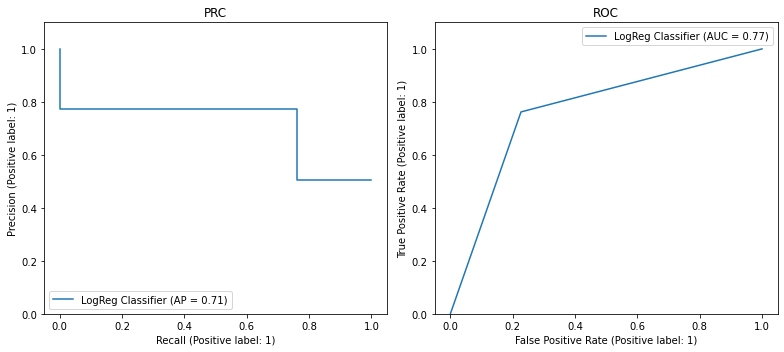

In [26]:
depict_pr_roc(y_test, y_logreg, 'LogReg Classifier')

In [27]:
precision, recall, _ = precision_recall_curve(y_test, y_logreg)
  # добавление очередной строки с характеристиками метода
df_metrics.loc['LogReg Classifier'] = [
      auc(recall, precision),
      roc_auc_score(y_test, y_logreg),
      best_logreg_C
]

  # по аналогии результаты следующих экспериментов можно будет собрать в табличку
df_metrics

,AUC_PR,AUC_ROC,reg_const
Random Classifier,0.752833,0.500000,0.0000
SVC Classifier,0.828501,0.765779,0.0001
LogReg Classifier,0.828581,0.767731,0.0010


**Вопрос:** Сравните результаты LR и SVM с точки зрения всех вычисленных критериев качества, объясните различия (если они есть).



**Ответ:** Показатели auc-pr и auc-roc почти идентичны. Единственное различие заключается в разных значения параметра регуляризации C.

#### __Задание 1.2. Визуализация в подходах SVM, LR__ (0.5 балла)



В названии метода опорных векторов присутствуют некоторые "опорные векторы". По сути, это объекты из обучающей выборки, которые задали положение разделяющей гиперплоскости.

* Сгенерируйте синтетические данные с помощью `make_classification` __с 2 признаками__, обучите на нём метод опорных векторов. В этот раз воспользуйтесь `SVC(kernel='linear')`, так как только в нём есть информация об опорных векторах, а в `LinearSVC` нет. Не забудьте зафиксировать seed для воспроизводимости

* Визуализируйте разделяющую прямую, все объекты и выделите опорные векторы (атрибут `support_vectors_`).

In [28]:
import seaborn as sns

In [29]:
X, y = make_classification(
    n_samples=10000, n_features=2, n_informative=2, n_redundant=0, random_state=42
)

In [30]:
from sklearn.svm import SVC

svc = SVC(kernel='linear', random_state=1, probability=True)
svc.fit(X, y)

SVC(kernel='linear', probability=True, random_state=1)

In [31]:
svc.decision_function(X)

array([-2.08522378, -1.35995263,  2.39843022, ..., -2.0970783 ,
        1.18929898, -2.76967663])

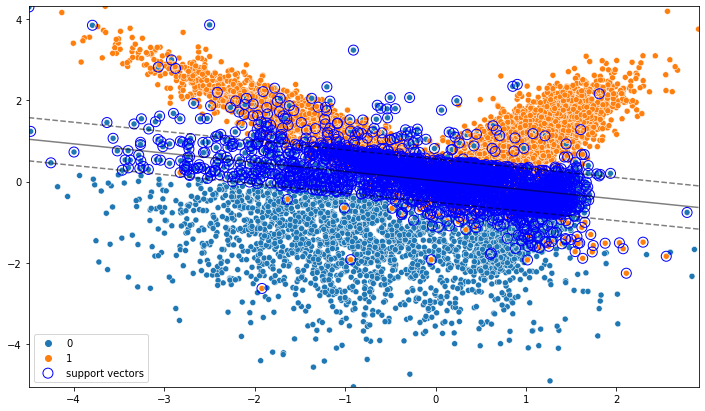

In [32]:
def plot_svm_2D(X, y, model,  plot_support=True):

    #создали сетку
    xx = np.linspace(X[:,0].min(), X[:,0].max(), 30)
    yy = np.linspace(X[:,1].min(), X[:,1].max(), 30)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T

    #Ответы модели для сетки для отрисовки разделяющей прямой
    Z = model.decision_function(xy).reshape(len(YY), len(XX))
    
    plt.figure(figsize=(12, 7))

    plt.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5, linestyles=['--', '-', '--'])


    #Отрисовали выборку
    sns.scatterplot(X[:, 0], X[:, 1], hue=y)
#     plt.scatter(X[:, 0], X[:, 1])

    #Отрисовали опорные векторы
    if plot_support:
        plt.scatter(model.support_vectors_[:, 0],
                    model.support_vectors_[:, 1],
                   label='support vectors',
                   s=100,
                   linewidth=1,
                   edgecolor="blue",
                   facecolors='none')

    plt.legend()

plot_svm_2D(X, y, svc)

**Вопрос:** какие объекты выделяются как "опорные"?



**Ответ:** Опорными становяться объекты, которые находяться близко к разделяющей прямой, то есть у которых маленькое расстояние.

В отличие от метода опорных векторов, логистическая регрессия не пытается построить разделяющую гиперплоскость с максимальным отступом, а приближает в каждой точке пространства объектов вероятность положительных ответов $p(y=+1|x)$. Попробуйте нарисовать это распределение на плоскости, не забудьте отметить на ней все объекты.

In [33]:
logreg = LogisticRegression(random_state=1)
logreg.fit(X, y)

LogisticRegression(random_state=1)

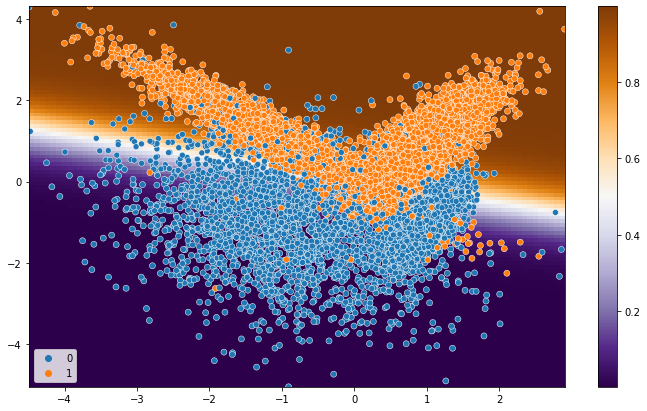

In [34]:
def plot_logreg_2D(X, y, model):

    #создали сетку
    xx = np.linspace(X[:,0].min(), X[:,0].max(), 100)
    yy = np.linspace(X[:,1].min(), X[:,1].max(), 100)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T

    #Ответы модели для сетки для отрисовки распределения
#     Z = logreg.predict(xy)
    Z = logreg.predict_proba(xy)[:, 1]
    Z = Z.reshape((xx.shape[0], -1)).T
    
    plt.figure(figsize=(12, 7))
    
    image = plt.imshow(Z, interpolation='nearest',
                       extent=(xx.min(), xx.max(), yy.min(), yy.max()),
                       aspect='auto', origin='lower', cmap=plt.cm.PuOr_r)

    #Отрисовали выборку
    sns.scatterplot(X[:, 0], X[:, 1], hue=y)
#     plt.scatter(X[:, 0], X[:, 1],
#                 cmap=plt.cm.Paired)

    plt.colorbar(image)


plot_logreg_2D(X, y, logreg)

**Вопрос:** Как на картинке визуализирована область, где модель не уверена ($p(y=+1|x) = 0.5$)? Как это обосновать теоритечески?



**Ответ:** модель не уверена, когда наблюдение находиться близко к гиперплоскости, потому что там маленький отступ (М). 

#### __Задание 2. Калибровка вероятностей__ (1 балл)



Перейдём к оценке качества выдаваемых алгоритмами вероятностей. Начнём с калибровочных кривых.

Допустим, алгоритм возвращает некоторые числа от нуля до единицы. Хорошо ли они оценивают вероятность?

Хорошо откалиброванный  классификатор должен выдавать значения так, чтобы среди образцов, для которых он дал значение, близкое к $\alpha$, примерно $\alpha * 100 \%$ фактически принадлежали к положительному классу. (Например, если классификатор выдает 0.3 для некоторых, то 30% из них должны принадлежать классу 1)

Для построения калибровочной криовой используем следующий алгоритм:

Разобьем отрезок $[0, 1]$ на несколько маленьких отрезков одинаковой длины.

Рассмотрим $i$-й отрезок с границами $[a_i, b_i]$ и предсказания $p_1, p_2, \dots, p_k$, которые попали в него. Пусть им соответствуют истинные ответы $y_1, y_2, \dots, y_k$. Если алгоритм выдает корректные вероятности, то среди этих истинных ответов должно быть примерно $(a_i + b_i) / 2$ единиц. Иными словами, если нарисовать кривую, у которой по оси X отложены центры отрезков, а по оси Y — доли единичных ответов этих в отрезках, то она должна оказаться диагональной.

Ниже приведена функция, которая должна рисовать такие кривые. В ней допущено две ошибки — найдите и исправьте их.

In [35]:
def plot_calibration_curve(y_test, preds):
    bin_middle_points = []
    bin_real_ratios = []
    n_bins = 10
    for i in range(n_bins):
        l = 1.0 / n_bins * i
        r = 1.0 / n_bins * (i + 1)
#         bin_middle_points.append((l - r) / 2) # тут должен быть +
        bin_middle_points.append((l + r) / 2)
#         bin_real_ratios.append(np.min(y_test[(preds >= l) & (preds < r)] == 1)) # вместо min должен быть mean
        bin_real_ratios.append(np.mean(y_test[(preds >= l) & (preds < r)] == 1)) 
    plt.figure(figsize=(6,6))
    plt.plot(bin_middle_points, bin_real_ratios)
    plt.plot(np.arange(0, 1.1, 0.1), np.arange(0, 1.1, 0.1), color='green', linestyle='--')
    plt.ylim([-0.05, 1.05])
    plt.xlim([-0.05, 1.05])
    plt.xlabel('predicted probability')
    plt.ylabel('fraction of positives')
    plt.legend(['model', 'ideal'])
    plt.grid()

In [36]:
np.arange(0, 1.1, 0.1)

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

Сгенерируйте синтетические данные аналогично использованным в самом первом задании. Постройте калибровочные кривые на тестовой части для логистической регрессии и метода опорных векторов (не забудьте перевести его предсказания в $[0;1]$).

Отрисуйте калибровочную кривую идеально откалиброванной модели (диагональ)

In [37]:
X, y = make_classification(
    n_samples=10000, n_features=10, n_informative=5, n_redundant=5, random_state=123)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [38]:
from sklearn.svm import SVC

SVC = SVC(kernel='linear', random_state=1, probability=True)
SVC.fit(X_train, y_train)

probs_svc = SVC.predict_proba(X_test)[:, 1]

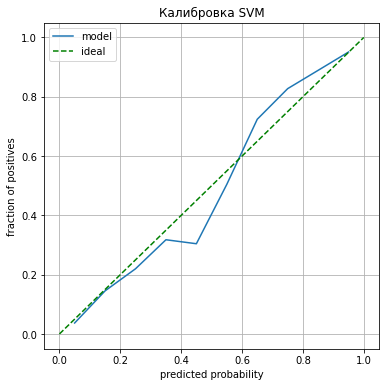

In [39]:
plot_calibration_curve(y_test, probs_svc)
plt.title('Калибровка SVM');

In [40]:
Logreg = LogisticRegression(random_state=2)
Logreg.fit(X_train, y_train)

probs_logreg = Logreg.predict_proba(X_test)[:, 1]

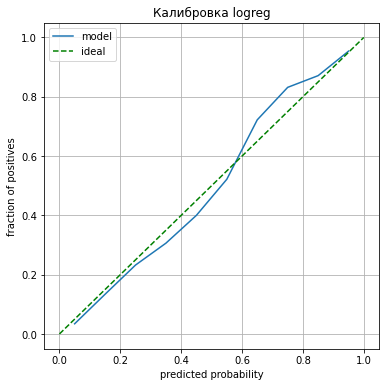

In [41]:
plot_calibration_curve(y_test, probs_logreg)
plt.title('Калибровка logreg');

**Вопрос**: хорошо ли откалиброваны кривые для SVM, логистической регрессии?

**Ответ:** В обоих кривых есть погрешности, но невооруженным глазом кажется, что логистическая регрессия отколибрована лучше. SVM ошибается больше на промежутке от 0.2 до 0.6, где она выдает вероятности ниже, чем есть на самом деле. От 0.6 до 1 модели ведут себя похожим образом. Тем не менее, логистическая регрессия кажется более сглаженной. 

Изучите распределение ответов классификаторов (постройте гистограммы с помощью `plt.hist`).

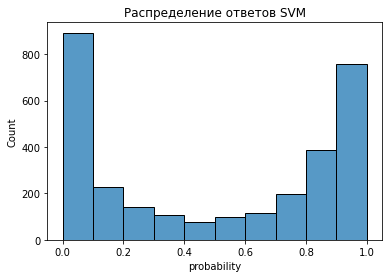

In [42]:
sns.histplot(probs_svc, bins=10)
plt.title('Распределение ответов SVM')
plt.xlabel('probability');

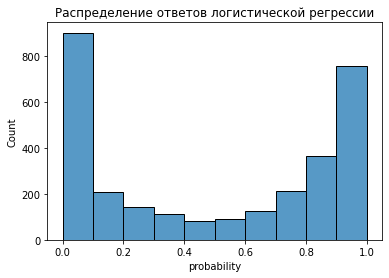

In [43]:
sns.histplot(probs_logreg, bins=10)
plt.title('Распределение ответов логистической регрессии')
plt.xlabel('probability');

**Вопрос:** Чем они различаются? Чем вы можете объяснить это?

**Ответ:** Почти не различаются. 

Воспользуйтесь `CalibratedClassifierCV` из `sklearn` для калибровки вероятностей метода опорных векторов на обучении и постройте с его помощью  предсказания для тестовой выборки.

In [44]:
from sklearn.calibration import CalibratedClassifierCV

svm = LinearSVC(random_state=2)
clf = CalibratedClassifierCV(svm) 
clf.fit(X_train, y_train)
probs_svm = clf.predict_proba(X_test)[:, 1]

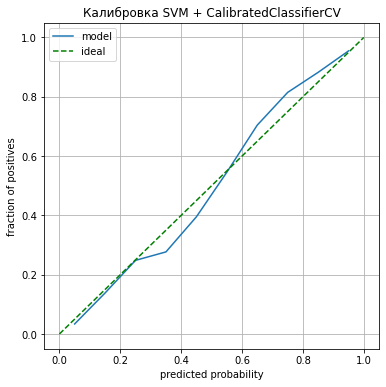

In [45]:
plot_calibration_curve(y_test, probs_svm)
plt.title('Калибровка SVM + CalibratedClassifierCV');

**Вопрос:** Улучшилась ли калибровочная кривая?

**Ответ:** Да, при добавлении CalibratedClassifierCV калибровочная кривая стала более гладкой и близкой к идеальной траектории. На промежутках от 0.2 до 0.6 и от 0.6 до 1 она стала менее хаотичной и лучше приближает идеальную кривую по сравнению с обучным SVM. 

##### __Бонус: Авторское решение__ (0.5 балла)

Реализуйте свою функцию для калибровки вероятностей, используя любой из известных подходов. Кратко опишите ваш подход и продемонстрируйте результаты. Ключевые слова для вдохновения: `Platt`, `Isotonic`.

In [46]:
#your code here

# Часть 2. Обработка категориальных переменных (4 балла + 1.5 бонус)

Как мы знаем, перекодировать категориальную переменную в список чисел (к примеру 1, 2, 3, ..., n) плохо, поскольку это бы задало на множестве ее значений некоторый порядок, не имеющий смысла.

В этой части мы рассмотрим два основных способа обработки категориальных значений:
- One-hot-кодирование
- Счётчики (CTR, mean-target кодирование, ...) — каждый категориальный признак заменяется на среднее значение целевой переменной по всем объектам, имеющим одинаковое значение в этом признаке.

Начнём с one-hot-кодирования. Допустим наш категориальный признак $f_j(x)$ принимает значения из множества $C=\{c_1, \dots, c_m\}$. Заменим его на $m$ бинарных признаков $b_1(x), \dots, b_m(x)$, каждый из которых является индикатором одного из возможных категориальных значений:
$$
b_i(x) = [f_j(x) = c_i]
$$

#### __Подготовка данных__

(бесценный шаг)

Разберем датасет [покупок велосипедов](https://www.kaggle.com/datasets/heeraldedhia/bike-buyers/): даны признаки покупателя, требуется предсказать, купит ли он/она велосипед



Замените пропуски в категориальных переменных на новую категорию (`'undefined'`)

Разделите признаки на 2 таблицы: категориальные и числовые признаки

In [47]:
df = pd.read_csv('bike_buyers.csv')

In [48]:
# Заменим пропуски категориальных переменных
categorical = ['Marital Status', 'Gender', 'Children', 'Education', 'Occupation', 'Home Owner', 'Cars', 
                 'Commute Distance', 'Region']
df[categorical] = df[categorical].fillna('undefined')
df = df.set_index('ID') # сделаем ID индексом

X = df.drop(columns=['Purchased Bike'])
y = (df['Purchased Bike'] == 'Yes').astype('int64')

In [49]:
# Разделим на категориальные признаки и числовые
X_numerical = X[['Income', 'Age']]
X_categorical = X[['Marital Status', 'Gender', 'Children', 'Education', 'Occupation', 'Home Owner', 'Cars', 
                 'Commute Distance', 'Region']]

В начале поработаем только с категориальными признаками

In [50]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_categorical, y, test_size=0.25, random_state=777, stratify=y)

In [51]:
X_train = X_train.astype(str)
X_test = X_test.astype(str)

#### __Задание 3. OrdinalEncoder__  (0.5 балла)

Закодируйте категориальные признаки с помощью `OrdinalEncoder`. Посчитайте качество (в этом задании будем работать c __`AUC-PR`__) при применении логистической регрессии. Замерьте время, потребовавшееся на обучение модели, с учетом кодирования признаков.

In [52]:
np.random.seed(123)
from sklearn.preprocessing import OrdinalEncoder
enc1 = OrdinalEncoder()

X_train_enc1 = enc1.fit_transform(X_train)
X_test_enc1 = enc1.transform(X_test)

In [53]:
from sklearn.metrics import average_precision_score
from timeit import default_timer as timer

LOGreg = LogisticRegression(random_state=1)

start = timer()
LOGreg.fit(X_train_enc1, y_train)
end = timer()
time = end - start

print(f'Время на обучение с OrdinalEncoder: {time}')

Время на обучение с OrdinalEncoder: 0.015718917000015153


In [54]:
preds_enc1 = LOGreg.predict(X_test_enc1)

auc_pr_enc1 = average_precision_score(y_test, preds_enc1)

print(f'AUC-PR с OrdinalEncoder: {auc_pr_enc1}')

AUC-PR с OrdinalEncoder: 0.5672666666666667


#### __Задание 4. One-Hot Encoding__ (0.5 балла)



Закодируйте все категориальные признаки с помощью one-hot-кодирования. Обучите логистическую регрессию и посмотрите, как изменилось качество модели (в сравнении с тем, что было до кодирования). Измерьте время, потребовавшееся на кодирование категориальных признаков и обучение модели.

In [55]:
np.random.seed(123)
from sklearn.preprocessing import OneHotEncoder

enc2 = OneHotEncoder()

start = timer()
X_train_enc2 = enc2.fit_transform(X_train)
X_test_enc2 = enc2.transform(X_test)
end = timer()
time = end - start

print(f'Время, потребовавшееся на кодирование категориальных признаков с OneHotEncoder: {time}')

Время, потребовавшееся на кодирование категориальных признаков с OneHotEncoder: 0.016299958000018933


In [56]:
logreg_ohe = LogisticRegression(random_state=1)

start = timer()
logreg_ohe.fit(X_train_enc2, y_train)
end = timer()
time = end - start

print(f'Время на обучение с OneHotEncoder: {time}')

Время на обучение с OneHotEncoder: 0.02724579200000221


In [57]:
preds_enc2 = logreg_ohe.predict(X_test_enc2)

auc_pr_enc2 = average_precision_score(y_test, preds_enc2)

print(f'AUC-PR с OneHotEncoder: {auc_pr_enc2}')

AUC-PR с OneHotEncoder: 0.5902978142076503


Как можно заметить, one-hot-кодирование может сильно увеличивать количество признаков. Это сказывается на объеме необходимой памяти, особенно, если некоторый признак имеет большое количество значений.


#### __Задание 5. Mean-target Encoding__ (1 балл)

> Проблемы разрастания числа признаков можно избежать в другом способе кодирования категориальных признаков — mean-target encoding (для простоты будем называть это __счётчиками__). Сравним эффективность методов в рамках нашей маркетинговой задачи.

> Основная идея в том, что важны не сами категории, а значения целевой переменной, которые имеют объекты этой категории. Каждый категориальный признак мы заменим средним значением целевой переменной по всем объектам этой же категории:

$$
g_j(x, X) = \frac{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)][y_i = +1]}{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)]}
$$

Закодируйте категориальные переменные с помощью счётчиков (ровно так, как описано выше, без каких-либо хитростей). Обучите логистическую регрессию и посмотрите на качество модели на тестовом множестве.

Сравните время обучения с предыдущими экспериментами (с учетом кодирования признаков).

In [58]:
class MeanTargetEncoder():
    def __init__(self):
        self.means = {}
        
    def fit(self, X, y):
        x = X.copy()
        for column in x.columns:
            numerator = {}
            denominator = {}
            mean = {}
            for value_x, value_y in zip(x[column], y):
                if value_x not in numerator.keys():
                    numerator[value_x] = value_y
                    denominator[value_x] = 1
                else:
                    numerator[value_x] = numerator[value_x] + value_y
                    denominator[value_x] = denominator[value_x] + 1
                
                mean[value_x] = numerator[value_x]/denominator[value_x]
        
            self.means[column] = mean
            
        return x
            
    def transform(self, X):
        x = X.copy()
        for column in x.columns:
            x[column] = x[column].replace(self.means[column])
            
        return x
    
    def fit_transform(self, X, y):
        x = X.copy()
        for column in x.columns:
            numerator = {}
            denominator = {}
            mean = {}
            for value_x, value_y in zip(x[column], y):
                if value_x not in numerator.keys():
                    numerator[value_x] = value_y
                    denominator[value_x] = 1
                else:
                    numerator[value_x] = numerator[value_x] + value_y
                    denominator[value_x] = denominator[value_x] + 1
                
                mean[value_x] = numerator[value_x]/denominator[value_x]
        
            self.means[column] = mean
        
            x[column] = x[column].replace(mean)
            
        return x

In [59]:
np.random.seed(123)
enc3 = MeanTargetEncoder()
start = timer()
X_train_enc3 = enc3.fit_transform(X_train, y_train)
X_test_enc3 = enc3.transform(X_test)
end = timer()
time = end - start

print(f'Время на кодирование с MeanTargetEncoder: {time}')

Время на кодирование с MeanTargetEncoder: 0.02982795799999849


In [60]:
X_train_enc3.head()

,Marital Status,Gender,Children,Education,Occupation,Home Owner,Cars,Commute Distance,Region
ID,,,,,,,,,
17894,0.415423,0.504155,0.568000,0.529915,0.484848,0.478599,0.610465,0.535581,0.488372
12195,0.552632,0.504155,0.571429,0.543307,0.440559,0.478599,0.387218,0.465116,0.430079
21006,0.552632,0.504155,0.568000,0.437186,0.482759,0.489270,0.610465,0.535581,0.488372
28858,0.552632,0.463158,0.571429,0.529915,0.478947,0.478599,0.610465,0.566667,0.430079
20870,0.552632,0.504155,0.459627,0.466165,0.482759,0.478599,0.555000,0.535581,0.488372


In [61]:
logreg_mte = LogisticRegression(random_state=1)

start = timer()
logreg_mte.fit(X_train_enc3, y_train)
end = timer()
time = end - start

print(f'Время на обучение с MeanTargetEncoder: {time}')

Время на обучение с MeanTargetEncoder: 0.019600667000020167


In [62]:
preds_enc3 = logreg_mte.predict(X_test_enc3)

auc_pr_enc3 = average_precision_score(y_test, preds_enc3)

print(f'AUC-PR с MeanTargetEncoder: {auc_pr_enc3}')

AUC-PR с MeanTargetEncoder: 0.5739075630252101


Самое маленькое время на обучение у логистической регрессии с OrdinalEncoder, на втором месте MeanTargetEncoder, а дольше всех обучается регрессия с OneHotEncoder, видимо, потому что там создается больше всего дополнительных признаков. 

##### __Бонус: Эффективная реализация (1 балл)__

Здесь и далее реализуйте вычисление счетчиков с помощью трансформера (наследуйтесь от классов `BaseEstimator, TransformerMixin` из `sklearn.base`). Обратите внимание, что все вычисления должны быть векторизованными, трансформер не должен модифицировать передаваемую ему выборку inplace, а все необходимые статистики нужно считать только по обучающей выборке в методе `fit`. Ваш трансформер должен принимать при инициализации список из категориальных признаков и изменять только их.

In [63]:
#your code here

_______

__Методы борьбы с переобучением счетчиков__


Отметим, что mean-target encoding признаки сами по себе являются классификаторами и, обучаясь на них, мы допускаем "утечку" целевой переменной в признаки. Это ведёт к __переобучению__, поэтому считать такие признаки необходимо таким образом, чтобы при вычислении для конкретного объекта его __целевая метка не использовалась__.

Это можно делать следующими способами:
1. Вычислять значение счётчика по всем объектам расположенным выше в датасете (например, если у нас выборка отсортирована по времени).
2. Вычислять по фолдам, то есть делить выборку на некоторое количество частей и подсчитывать значение признаков по всем фолдам кроме текущего (как делается в кросс-валидации).
3. Внесение некоторого шума в посчитанные признаки.

#### __Задание 6. Пошумим__  (0.5 балла)

Реализуйте корректное вычисление счётчиков самым простым способом — добавление шума к значениям.  При этом постарайтесь найти баланс между борьбой с переобучением и сохранением полезности признаков. Снова обучите логистическую регрессию, оцените качество.

In [64]:
class MeanTargetEncoderWithNoise():
    def __init__(self):
        self.means = {}
        
    def fit(self, X, y):
        x = X.copy()
        for column in x.columns:
            numerator = {}
            denominator = {}
            mean = {}
            for value_x, value_y in zip(x[column], y):
                noise = np.random.uniform(-0.3, 0.3)
                if value_x not in numerator.keys():
                    numerator[value_x] = value_y + noise
                    denominator[value_x] = 1
                else:
                    numerator[value_x] = numerator[value_x] + value_y + noise
                    denominator[value_x] = denominator[value_x] + 1
                
                mean[value_x] = numerator[value_x]/denominator[value_x]
        
            self.means[column] = mean
            
        return x
            
    def transform(self, X):
        x = X.copy()
        for column in x.columns:
            x[column] = x[column].replace(self.means[column])
            
        return x
    
    def fit_transform(self, X, y):
        x = X.copy()
        for column in x.columns:
            numerator = {}
            denominator = {}
            mean = {}
            for value_x, value_y in zip(x[column], y):
                noise = np.random.uniform(-0.3, 0.3)
                if value_x not in numerator.keys():
                    numerator[value_x] = value_y + noise
                    denominator[value_x] = 1
                else:
                    numerator[value_x] = numerator[value_x] + value_y + noise
                    denominator[value_x] = denominator[value_x] + 1
                
                mean[value_x] = numerator[value_x]/denominator[value_x]
        
            self.means[column] = mean
        
            x[column] = x[column].replace(mean)
            
        return x

In [65]:
np.random.seed(123)

enc4 = MeanTargetEncoderWithNoise()
start = timer()
X_train_enc4 = enc4.fit_transform(X_train, y_train)
X_test_enc4 = enc4.transform(X_test)
end = timer()
time = end - start

print(f'Время на кодирование с MeanTargetEncoderWithNoise: {time}')

Время на кодирование с MeanTargetEncoderWithNoise: 0.04850225000001274


In [66]:
X_train_enc4.head()

,Marital Status,Gender,Children,Education,Occupation,Home Owner,Cars,Commute Distance,Region
ID,,,,,,,,,
17894,0.414043,0.493753,0.544945,0.518889,0.488688,0.467935,0.608043,0.537398,0.484490
12195,0.561699,0.493753,0.586338,0.544541,0.447510,0.467935,0.391463,0.444292,0.439127
21006,0.561699,0.493753,0.544945,0.428045,0.485254,0.492941,0.608043,0.537398,0.484490
28858,0.561699,0.461984,0.586338,0.518889,0.480908,0.467935,0.608043,0.557497,0.439127
20870,0.561699,0.493753,0.457819,0.478634,0.485254,0.467935,0.565017,0.537398,0.484490


In [67]:
logreg_mtewn = LogisticRegression(random_state=1)

start = timer()
logreg_mtewn.fit(X_train_enc4, y_train)
end = timer()
time = end - start

print(f'Время на обучение с MeanTargetEncoderWithNoise: {time}')

Время на обучение с MeanTargetEncoderWithNoise: 0.019741250000009813


In [68]:
preds_enc4 = logreg_mte.predict(X_test_enc4)

auc_pr_enc4 = average_precision_score(y_test, preds_enc4)

print(f'AUC-PR с MeanTargetEncoder: {auc_pr_enc4}')

AUC-PR с MeanTargetEncoder: 0.5803333333333334


**Вопрос:** Сделайте выводы. Помогло ли добавление шума? Почему?

**Ответ:**: Качество выросло, но не сильно, к тому же оно может меняться от перезапуска. Тем не менее, в среднем этот encoder, действительно, должен работать чуть лучше, потому что спасает от переобучения, ведь теперь мы обучаемся не буквально на таргете, что заставляет модель меньше подстраиваться под данные. 

##### __Бонус: другой подход__ (0.5 балла)

Посчитайте корректные счётчики первым или вторым способов из описанных выше (не забудьте добавить и шум).




In [69]:
#your code here

#### __Задание 7. Сглаживание счетчиков__  (1 балл)

> Теперь ответим на следующий вопрос: что будет, если некоторая категория встречается в выборке всего несколько раз? По этой причине производится сглаживание счётчиков. Например, на практике хорошие результаты показывает использование сглаживания средним по всей выборке:
$$
g_j(x, X) = \frac{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)][y_i = +1] + C \times global\_mean}{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)] + C}
$$
где $global\_mean$ — доля объектов положительного класса в выборке, $C$ — параметр, определяющий степень сглаживания (можно использовать 10 или подобрать для каждого признака свой). Идея в том, что мы "разбавляем" среднее значение по категории глобальным средним значением. И тем меньше, чем большее количество объектов этой категории встречается в выборке.

> Вместо среднего значения целевой переменной для сглаживания можно использовать любое другое значение от 0 до 1 (этот параметр иногда называют $prior$). Можно сделать несколько признаков с разными значениями параметра. На практике в задачах бинарной классификации полезными бывают даже отрицательные значения!

Добавьте сглаживание, описанное выше и повторите эксперименты. Подберите $C$, чтобы качество было лучше, чем при использовании One-Hot-Encoding


In [70]:
class MeanTargetEncoderSmooth():
    def __init__(self, C):
        """
        C - smoothing parameter
        """
        self.means = {}
        self.C = C
    def fit(self, X, y):
        x = X.copy()
        global_mean = y.mean()
        for column in x.columns:
            numerator = {}
            denominator = {}
            mean = {}
            for value_x, value_y in zip(x[column], y):
                if value_x not in numerator.keys():
                    numerator[value_x] = value_y + self.C * global_mean
                    denominator[value_x] = 1 + self.C
                else:
                    numerator[value_x] = numerator[value_x] + value_y
                    denominator[value_x] = denominator[value_x] + 1
                
                mean[value_x] = numerator[value_x]/denominator[value_x]
        
            self.means[column] = mean
            
        return x
            
    def transform(self, X):
        x = X.copy()
        for column in x.columns:
            x[column] = x[column].replace(self.means[column])
            
        return x
    
    def fit_transform(self, X, y):
        x = X.copy()
        global_mean = y.mean()
        for column in x.columns:
            numerator = {}
            denominator = {}
            mean = {}
            for value_x, value_y in zip(x[column], y):
                if value_x not in numerator.keys():
                    numerator[value_x] = value_y + self.C * global_mean
                    denominator[value_x] = 1 + self.C
                else:
                    numerator[value_x] = numerator[value_x] + value_y
                    denominator[value_x] = denominator[value_x] + 1
                
                mean[value_x] = numerator[value_x]/denominator[value_x]
        
            self.means[column] = mean
        
            x[column] = x[column].replace(mean)
            
        return x

In [71]:
# Найдем лучшую С с точки зрения auc-pr

np.random.seed(123)

bestC = {'C': 0, 'auc-pr': 0}
for C in range(0, 200):
    enc5 = MeanTargetEncoderSmooth(C)
    X_train_enc5 = enc5.fit_transform(X_train, y_train)
    X_test_enc5 = enc5.transform(X_test)

    logreg_mtes = LogisticRegression(random_state=1)
    logreg_mtes.fit(X_train_enc5, y_train)

    preds_enc5 = logreg_mtes.predict(X_test_enc5)

    auc_pr_enc5 = average_precision_score(y_test, preds_enc5)
    
    if auc_pr_enc5 > bestC['auc-pr']:
        bestC['C'] = C
        bestC['auc-pr'] = auc_pr_enc5

In [72]:
bestC

{'C': 29, 'auc-pr': 0.5905}

In [73]:
np.random.seed(123)
enc5 = MeanTargetEncoderSmooth(29)
start = timer()
X_train_enc5 = enc5.fit_transform(X_train, y_train)
X_test_enc5 = enc5.transform(X_test)
end = timer()
time = end - start
    
print(f'Время на кодирование с MeanTargetEncoderSmooth: {time}')

Время на кодирование с MeanTargetEncoderSmooth: 0.029710000000022774


In [74]:
X_train_enc5.head()

,Marital Status,Gender,Children,Education,Occupation,Home Owner,Cars,Commute Distance,Region
ID,,,,,,,,,
17894,0.419858,0.502458,0.551680,0.524558,0.484215,0.478745,0.591834,0.530266,0.487536
12195,0.547058,0.502458,0.550856,0.531786,0.447434,0.478745,0.396470,0.468093,0.433722
21006,0.547058,0.502458,0.551680,0.442801,0.482402,0.488392,0.591834,0.530266,0.487536
28858,0.547058,0.464447,0.550856,0.524558,0.479263,0.478745,0.591834,0.550058,0.433722
20870,0.547058,0.502458,0.462940,0.468881,0.482402,0.478745,0.545671,0.530266,0.487536


In [75]:
logreg_mtes = LogisticRegression(random_state=1)

start = timer()
logreg_mtes.fit(X_train_enc5, y_train)
end = timer()
time = end - start

print(f'Время на обучение с MeanTargetEncoderSmooth: {time}')

Время на обучение с MeanTargetEncoderSmooth: 0.018377624999999398


In [76]:
preds_enc5 = logreg_mtes.predict(X_test_enc5)

auc_pr_enc5 = average_precision_score(y_test, preds_enc5)

print(f'AUC-PR с MeanTargetEncoderSmooth: {auc_pr_enc5}')

AUC-PR с MeanTargetEncoderSmooth: 0.5905


In [77]:
print(f'Напомним, что AUC-PR с OneHotEncoder: {auc_pr_enc2}')

Напомним, что AUC-PR с OneHotEncoder: 0.5902978142076503


In [78]:
auc_pr_enc5 - auc_pr_enc2

0.00020218579234976275

Качество совсем немного, но выше, чем с OneHotEncoder.

#### **Задание 8. Числовые или категориальные?**  (0.5 балла)

Теперь добавим числовые признаки к признакам-счетчикам.


В данных есть пропуски - замените их средним значением признака



In [79]:
X_numerical = X_numerical.fillna(X_numerical.mean())

In [80]:
X_numerical.isna().sum()

Income    0
Age       0
dtype: int64

In [81]:
# Объединим категориальные и числовые признаки:
X_all = pd.merge(X_categorical, X_numerical, left_index=True, right_index=True)
X_all.head()

,Marital Status,Gender,Children,Education,Occupation,Home Owner,Cars,Commute Distance,Region,Income,Age
ID,,,,,,,,,,,
12496,Married,Female,1.0,Bachelors,Skilled Manual,Yes,0.0,0-1 Miles,Europe,40000.0,42.0
24107,Married,Male,3.0,Partial College,Clerical,Yes,1.0,0-1 Miles,Europe,30000.0,43.0
14177,Married,Male,5.0,Partial College,Professional,No,2.0,2-5 Miles,Europe,80000.0,60.0
24381,Single,undefined,0.0,Bachelors,Professional,Yes,1.0,5-10 Miles,Pacific,70000.0,41.0
25597,Single,Male,0.0,Bachelors,Clerical,No,0.0,0-1 Miles,Europe,30000.0,36.0


In [82]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_all, y, test_size=0.25, random_state=777, stratify=y)

 Сейчас для числовых признаков мы ищем линейную зависимость, что в общем случае  может быть неверной гипотезой. Тем не менее, у этих признаков есть довольно много уникальных значений (сколько?), поэтому применять к ним one-hot кодирование может оказаться излишним. Попробуйте закодировать эти признаки с помощью счетчиков (вместе и по отдельности). Стало ли лучше?

In [83]:
# Количество уникальных значений для каждого числового признака:
X_numerical.nunique()

Income    17
Age       54
dtype: int64

In [84]:
# Найдем лучшую С с точки зрения auc-pr

np.random.seed(123)

bestC = {'C': 0, 'auc-pr': 0}
for C in range(0, 200):
    mtes = MeanTargetEncoderSmooth(C)
    X_train_mtes = mtes.fit_transform(X_train, y_train)
    X_test_mtes = mtes.transform(X_test)

    logreg_mtes = LogisticRegression(random_state=1)
    logreg_mtes.fit(X_train_mtes, y_train)

    preds_mtes = logreg_mtes.predict(X_test_mtes)

    auc_pr_mtes = average_precision_score(y_test, preds_mtes)
    
    if auc_pr_mtes > bestC['auc-pr']:
        bestC['C'] = C
        bestC['auc-pr'] = auc_pr_mtes

In [85]:
bestC

{'C': 104, 'auc-pr': 0.6109365079365079}

In [86]:
np.random.seed(123)
mtes = MeanTargetEncoderSmooth(104)

X_train_mtes = mtes.fit_transform(X_train, y_train)
X_test_mtes = mtes.transform(X_test)

In [87]:
X_train_mtes.head()

,Marital Status,Gender,Children,Education,Occupation,Home Owner,Cars,Commute Distance,Region,Income,Age
ID,,,,,,,,,,,
17894,0.428970,0.499051,0.528640,0.514966,0.483299,0.479059,0.561807,0.520374,0.486077,0.458972,0.484087
12195,0.536006,0.499051,0.525043,0.515405,0.457727,0.479059,0.413672,0.472355,0.441115,0.500290,0.524667
21006,0.536006,0.499051,0.528640,0.452339,0.481983,0.486821,0.561807,0.520374,0.486077,0.505125,0.484593
28858,0.536006,0.467063,0.525043,0.514966,0.479791,0.479059,0.561807,0.527048,0.441115,0.425625,0.451569
20870,0.536006,0.499051,0.468146,0.472821,0.481983,0.479059,0.529798,0.520374,0.486077,0.462397,0.538913


In [88]:
logreg_mtes = LogisticRegression(random_state=1)

logreg_mtes.fit(X_train_mtes, y_train)

preds_mtes = logreg_mtes.predict(X_test_mtes)

auc_pr_mtes = average_precision_score(y_test, preds_mtes)

print(f'AUC-PR с добавлением численных признаков + MeanTargetEncoderSmooth: {auc_pr_mtes}')

AUC-PR с добавлением численных признаков + MeanTargetEncoderSmooth: 0.6109365079365079


При использовании MeanTargetEncoderSmooth и после подбора оптимального C качество значительно улучшилось у модели с добавленными числовыми признаками. 

> __Замечание.__ Усложнение методов вычисления счётчиков не делают результаты модели гарантированно лучше. Особенно с учётом того, что логистическая регрессия не такая сложная модель, чтобы переобучаться. Поэтому вы необязательно должны были получать на каждом шаге всё лучшие и лучшие результаты (но необходимые результаты у вас должны были получиться).



Как мы могли пронаблюдать, счётчики являются конкурентной альтернативой one-hot-кодированию. Опишите, какие плюсы и минусы использования счётчиков по сравнению с one-hot-кодированием вы заметили.

__Ответ:__ 

**Плюсы**: 

1. Счетчики не изменяют размер изначального датасета, то есть не создают дополнительных признаков, поэтому модель быстрее обучается. 
2. Счетчики более универсальны с точки зрения кастомизации, так как можно играться с параметрами и подбирать их оптимально для решаемой задачи.  

**Минусы**:

1. Приходиться бороться с переобучением. Если не добавлять шум или не взвешивать, то модель может переобучиваться, потому что мы, по сути, подсматриваем в таргет, чего делать очень нежелательно.

# Часть 3. Отбор признаков (2 балла)

Загрузим данные [UCI Adult Dataset](https://archive.ics.uci.edu/ml/datasets/Adult). Этот набор данных содержит информацию о годовых доходах отдельных людей. В качестве признакового описания используется различная информация о человеке (образование, профессия, брачный статус и т.д.). Целевая переменная является бинарной: больше ли годовой доход 50K долларов или нет.

In [89]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data

zsh:1: command not found: wget


In [90]:
columns = ['age', 'workclass', 'fnlwgt', 'education',
           'education-num', 'marital-status', 'occupation',
           'relationship', 'race', 'sex', 'capital-gain',
           'capital-loss', 'hours-per-week', 'native-country',
           'income']

df = pd.read_csv('adult.data', header=None, names=columns)
df['income'] = (df['income'] != " <=50K").astype('int32')
df.sample()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
20713,55,State-gov,199713,Bachelors,13,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,15,United-States,0


Важной частью процесса построения модели является отбор признаков. На практике многие признаки оказывают малое влияние на модель (при этом их расчёт занимает время) или даже негативно сказываются на качестве модели. Попробуем несколько подходов отбора признаков, оценим, как они влияют на качество модели и сколько времени занимают.



Разделите выборку на обучающую и тестовую в соотношении 3:1. Зафиксируйте `random_state=777`, также используйте `stratify`.

In [91]:
y = df['income']
X = df.drop(columns='income')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=777, stratify=y)

Давайте закодируем все категориальные признаки с помощью One-hot Encoding. Сколько новых признаков мы получим?

In [92]:
categorical = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 
               'race', 'sex', 'native-country']

X_train_categorical = X_train[categorical]
X_test_categorical = X_test[categorical]

ohe = OneHotEncoder()

X_train_categorical_enc = ohe.fit_transform(X_train_categorical).toarray()
X_test_categorical_enc = ohe.transform(X_test_categorical).toarray()

X_train_categorical_enc.shape

(24420, 102)

In [93]:
X_train_categorical_enc

array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.]])

Если считать, что категориальных признаков всего 8, то мы получили 102 - 8 = 94 новых признака. 

In [94]:
X_train_numeric = X_train.drop(columns=categorical).to_numpy()
X_test_numeric = X_test.drop(columns=categorical).to_numpy()
X_train_numeric

array([[    60, 194252,     14,   3103,      0,     40],
       [    41,  26669,     10,      0,      0,     40],
       [    18, 165754,     10,      0,      0,     30],
       ...,
       [    47, 152073,      9,      0,      0,     40],
       [    33, 222221,      9,   7298,      0,     45],
       [    25, 212522,      9,      0,      0,     40]])

In [95]:
X_train_enc = np.concatenate((X_train_categorical_enc, X_train_numeric), axis=1)
X_test_enc = np.concatenate((X_test_categorical_enc, X_test_numeric), axis=1)

В качестве основной модели будем использовать логистическую регрессию, а целевой метрики — `AUC-PR`. Обучите модель и посчитайте качество на тестовой выборке. Давайте запомним полученное значение.

In [96]:
logreg = LogisticRegression(random_state=1)

logreg.fit(X_train_enc, y_train)

preds = logreg.predict(X_test_enc)

auc_pr = average_precision_score(y_test, preds)

print(f'AUC-PR: {auc_pr}')

AUC-PR: 0.3571695338007116


#### __Задание 9. Встроенные методы (0.5 балла)__

Допустим, мы хотим оставить только 40 лучших признаков. Попробуем сделать это несколькими способами.

Начнём с отборам признаков с помощью линейной модели. Как известно, веса линейной модели означают вклад каждого признака в предсказание модели, а значит, модуль этого вклада можно интерпретировать как важность признаков. Такой метод отбора называются встроенным или embedded method, так как он заложен в особенности модели.

Оставьте 40 признаков с наибольшим модулем соответствующего параметра линейной модели. Обучите модели заново и оцените её качество. Замерьте скорость такого отбора признаков.



In [97]:
from sklearn.linear_model import LinearRegression

np.random.seed(123)

linreg = LinearRegression()
linreg.fit(X_train_enc, y_train)
coefs = linreg.coef_
indexes_top40 = np.argpartition(coefs, -40)[-40:]

In [98]:
X_train_top40 = X_train_enc[:, indexes_top40]
X_test_top40 = X_test_enc[:, indexes_top40]

logreg = LogisticRegression(random_state=1)

logreg.fit(X_train_top40, y_train)

preds_top40 = logreg.predict(X_test_top40)

auc_pr_top40 = average_precision_score(y_test, preds_top40)

print(f'AUC-PR: {auc_pr_top40}')

AUC-PR: 0.48727120490016723


In [99]:
print(f'Улучшение в качестве: {auc_pr_top40 - auc_pr}')
print(f'Улучшение в качестве в %: {(auc_pr_top40 - auc_pr)/auc_pr}')

Улучшение в качестве: 0.13010167109945564
Улучшение в качестве в %: 0.3642574709970866


Изменилось ли качество? Как?

Качество выросло очень заметно, в процентном отношении аж на 36%!

Подумаем, что мы не учли. Мы действовали в предположении, что признаки вносят вклад равномерно, и не учитывали их масштаб. Если мы умножим один из признаков в 100 раз, то без учёта регуляризации его вес уменьшится в эти же 100 раз. А мы на основе этого отбираем признаки! Давайте сначала отмасштабируем признаки одним из способов, а только потом будем удалять признаки.

Кстати, в таком случае надо пересчитать качество на всех признаках (сделайте это ниже). Если вы сделали нормирование признаков в самом начале, то попробуйте отобрать признаки на неотмасштабированных данных.

Что получилось?

In [100]:
from sklearn.preprocessing import MinMaxScaler

np.random.seed(123)

scaler = MinMaxScaler()

X_train_enc_scaled = scaler.fit_transform(X_train_enc)
X_test_enc_scaled = scaler.transform(X_test_enc)

linreg = LinearRegression()
linreg.fit(X_train_enc_scaled, y_train)
coefs = linreg.coef_
indexes_top40 = np.argpartition(coefs, -40)[-40:]

In [101]:
X_train_scaled_top40 = X_train_enc_scaled[:, indexes_top40]
X_test_scaled_top40 = X_test_enc_scaled[:, indexes_top40]

logreg = LogisticRegression(random_state=1)

logreg.fit(X_train_scaled_top40, y_train)

preds_scaled_top40 = logreg.predict(X_test_scaled_top40)

auc_pr_scaled_top40 = average_precision_score(y_test, preds_scaled_top40)

print(f'AUC-PR у отмасштабированных признаков: {auc_pr_scaled_top40}')

AUC-PR у отмасштабированных признаков: 0.4791850352322352


In [102]:
print(f'Изменение в качестве: {auc_pr_scaled_top40 - auc_pr_top40}')
print(f'Изменение в качестве в %: {(auc_pr_scaled_top40 - auc_pr_top40)/auc_pr_top40}')

Изменение в качестве: -0.00808616966793202
Изменение в качестве в %: -0.016594803030868046


Качество слегка упало  (╯ ° □ °） ╯

Вопрос на засыпку: one-hot кодирование возвращает нам единичные признаки-индикаторы. Попробуйте также отскалировать их, как и обычные числовые, и снова выбрать 40 главных по вкладу признаков. Изменился ли их список? Изменится ли качество?

Поскольку я использовал MinMaxScaler, я сразу же применил его на весь датасет, потому что с закодированными one-hot кодированием признаками ничего не произойдет. Это происходит из-за того, как MinMaxScaler кодирует признаки. Он приводит все значения к интервалу от 0 до 1 и делает это по следующей формуле: 
$$x_{scaled}=\frac{x-x_{min}}{x_{max}-x_{min}}$$
А поскольку после OHE у признака может быть всего 2 значения: 1 или 0, то есть x_min = 0, а x_max = 1, следовательно, с категориальными признаками ничего не происходит. 

#### __Задание 10. Методы фильтрации (0.5 балла)__


Давайте отбирать признаки умнее, а именно через подсчёт некоторой функции для каждого признака. На основании значений этой функции будем оставлять наиболее важные признаки. Методы этого семейства называют фильтрующими или  filter methods.

В качестве такой функции будем считать t-статистику:

$$t(j) = \frac{|\mu_+ - \mu_-|}{\sqrt{\frac{n_+ \sigma^2_+ + n_- \sigma^2_-}{n_+ + n_-}}},$$

где $\mu$, $\sigma$, $n$ соответственно среднее, стандартное отклонение и количество объектов каждого из классов.

Оставьте 40 признаков с наибольшим значением $t$, замерьте качество и скорость отбора признаков.



In [109]:
def t_calculator(X, y):
    results = []
    for column in range(0, X.shape[1]):
        x = X[:, column]
        mean_1 = x[y==1].mean()
        mean_0 = x[y==0].mean()
        var_1 = x[y==1].var()
        var_0 = x[y==0].var()
        n_1 = len(x[y==1])
        n_0 = len(x[y==0])
        t = np.abs(mean_1 - mean_0)/np.sqrt((n_1*var_1+n_0*var_0)/(n_1+n_0))
        results.append(t)
    return np.argpartition(results, -40)[-40:]

In [110]:
indexes = t_calculator(X_train_enc_scaled, y_train)
indexes # лучшие 40 признаков

array([ 31,   1,   9,  39,  86,  24,   0,  59,  58,  57,  55,  52,  51,
        50,  49,  48,  47,  42,  40,  38,  36,  33,  32,  30,  29,  27,
        25,  23,  21,  20,  19,  18,  10,   5, 102,   4, 104, 105, 106,
       107])

In [111]:
X_train_t= X_train_enc_scaled[:, indexes]
X_test_t = X_test_enc_scaled[:, indexes]

logreg = LogisticRegression(random_state=1)

logreg.fit(X_train_t, y_train)

pred = logreg.predict(X_test_t)

auc_pr = average_precision_score(y_test, pred)

print(f'AUC-PR: {auc_pr}')

AUC-PR: 0.5200847531567773


#### __Задание 11. Методы-обёртки__ (1 балл)

Третий из рассматриваемых нами методов работает следующим образом: мы исключаем по очереди один из признаков и смотрим, как это влияет на качество. Удаляем признаки таким жадным способом, пока не окажется выполненым некоторое условие (количество признаков или ухудшение качества). Более конкретно, на каждом шаге мы будем удалять такой признак $j$, что качество модели на множестве оставшихся признаков без $j$ максимально, то есть удалять мы будем наиболее бесполезный признак.

Заметим, что нельзя оценивать качество по тестовой выборке, иначе мы можем переобучиться, как, например, при настройке гиперпараметров. Разделите обучающую выборку на 2 части, на одной из них обучайте модель без одного из признаков,  на второй части оценивайте качество. Исходную тестовую выборку стоит использовать только для финальной оценки качества.

Снова оставьте только 40 признаков и оцените качество на тестовой выборке. Сколько времени занял такой отбор признаков?

In [102]:
X_train_test, X_val, y_train_test, y_val = train_test_split(X_train_enc_scaled, y_train, test_size=0.5, 
                                                       random_state=777, stratify=y_train)

In [103]:
def wrapper(X_train_, X_val_, y_train, y_val):
    X_train = X_train_.copy()
    X_val = X_val_.copy()
    resulted_columns = list(range(0, X_train.shape[1]))
    while X_train.shape[1] > 40:
        results = []
        for column in range(0, X_train.shape[1]):
            x_train = np.delete(X_train, column, axis=1)
            x_val = np.delete(X_val, column, axis=1)
            
            logreg = LogisticRegression(random_state=1)

            logreg.fit(x_train, y_train)

            preds = logreg.predict(x_val)

            auc_pr = average_precision_score(y_val, preds)
            
            results.append(auc_pr)
            
        remove = np.argmax(results)
        X_train = np.delete(X_train, remove, axis=1)
        X_val = np.delete(X_val, remove, axis=1)
        resulted_columns = np.delete(resulted_columns, remove)
    
    return resulted_columns

In [104]:
start = timer()
top40 = wrapper(X_train_test, X_val, y_train_test, y_val)
end = timer()
time = end - start
print(time)

624.822859


Очень долго...

In [105]:
X_train_top40 = X_train_enc_scaled[:, top40]
X_test_top40 = X_test_enc_scaled[:, top40]

logreg = LogisticRegression(random_state=1)

logreg.fit(X_train_top40, y_train)

preds = logreg.predict(X_test_top40)

auc_pr = average_precision_score(y_test, preds)

print(f'AUC-PR с использование wrapper (метода обертки): {auc_pr}')

AUC-PR с использование wrapper (метода обертки): 0.5376078676653111


Стоит отметить, что с помощью такого метода можно пойти и в обратную сторону. Попробуйте _добавлять_ по одному самому полезному признаку в выборку до тех пор, пока не наберется 40 штук. Найдется ли порог, при котором добавление следующих признаков будет только ухудшать качество модели?

In [150]:
def wrapper_1(X_train_, X_val_, y_train, y_val):
    X_train = X_train_.copy()
    X_val = X_val_.copy()
    resulted_columns = []
    auc_prs = []
    iters = 0 
    while len(resulted_columns) < 40:
        results = []
        for column in range(0, X_train.shape[1]):
            if column not in resulted_columns:
                columns = resulted_columns + [column]
                x_train = X_train[:, columns]
                x_val = X_val[:, columns]
            
                logreg = LogisticRegression(random_state=1)

                logreg.fit(x_train, y_train)

                preds = logreg.predict(x_val)

                auc_pr = average_precision_score(y_val, preds)
            
                results.append(auc_pr)
            else:
                continue
            
        best_column = np.argmax(results)
        best_auc_pr = results[best_column]
        if (len(auc_prs) == 0) or (best_auc_pr >= auc_prs[-1]):
            auc_prs.append(best_auc_pr)
            resulted_columns.append(best_column)
            iters += 1 
        elif best_auc_pr < auc_prs[-1]:
            iters += 1
            return resulted_columns, iters
    
    return resulted_columns, iters

In [151]:
np.random.seed(1)
start = timer()
top, iters = wrapper_1(X_train_test, X_val, y_train_test, y_val)
end = timer()
time = end - start
print(time)

5.2453960840002765


In [152]:
iters

5

Уже при добавлении 5-го признака модель теряет в качестве. 

In [153]:
X_train_top = X_train_enc_scaled[:, top]
X_test_top = X_test_enc_scaled[:, top]

logreg = LogisticRegression(random_state=1)

logreg.fit(X_train_top, y_train)

preds = logreg.predict(X_test_top)

auc_pr = average_precision_score(y_test, preds)

print(f'AUC-PR с использование wrapper_1: {auc_pr}')

AUC-PR с использование wrapper_1: 0.44919678880878366


Давайте подведём итоги по отбору признаков. Назовите преимущества и недостатки каждого из методов. Какой метод привёл к наилучшему качеству?

**Ответ:**

1. Встроенные методы:
**Плюсы**: Доступны из пакетов. Не надо реализовывать самому. Быстро обучаются. Если соблюдать все правила (обработка категориальных признаков и масштабирование всей выборки), выдают довольно неплохие результаты. 

**Минусы**: Нужно не забыть соблюсти все эти правила. К тому же в качестве все-так уступают более изысканным методам. 

2. Методы фильтрации:
**Плюсы**: Легко реализовать. Быстро обучаются. Качество лучше, чем у встроенных методов, почти такое же, как у методовов оберток.

**Минусы**: Скорее всего, может быть чувствительна к выбросам. Когда мы считаем t-статистику, мы, вообще говоря, предполагаем, что наши данные распредлены по законам нормального распределения, что не всегда так. 

3. Методы-обёртки:
**Плюсы**: Показывают лучшее качество из всех рассмотренных методов. 

**Минусы**: Очень долго обучаются, потому что приходиться проходиться по всем колонкам и каждый раз замерять качество. Даже в нашем примере со 100 с лишним признаков wrapper обучался около 10 минут. Сложнореализуемые. 

# Часть 4. Оценка экономического эффекта модели (2 балла)



В данной части мы займемся тем, что от вас скорее всего потребуется на реальной работе (помимо перекладки `json`, разумеется). А именно:
- мы соберем несколько специализированных метрик качества,
- попытаемся настроить модель на максимизацию _прибыли_,
- оценим, сколько вообще получится заработать на этом.

Разумеется, здесь будет сделано множество упрощающих жизнь допущений, но обо всем по порядку. Если вы всё прослушали на экономике, то напомним, что выручка — это сколько денег нам принесли клиенты, а прибыль — выручка за вычетом расходов на зарплату и прочее.


#### __Задание 12. Прогноз по доходам и расходам__ (1 балл)

В этой части мы будем работать с данными [UCI Bank Marketing Dataset](https://archive.ics.uci.edu/ml/datasets/bank+marketing). Этот датасет содержит информацию о банковском телефонном маркетинге.

__Объектом__ здесь является телефонный звонок потенциальному клиенту с предложением некоторой услуги (утверждается, что это краткосрочный депозит). В качестве признакового описания используются характеристики клиента (образование, брак и т.д.), данные о звонке и различные экономические индикаторы - более подробная информация представлена в файле `bank-additional-names.txt`.
__Целевая переменная__ - ответ клиента (согласился ли он открыть депозит?)

In [211]:
# !wget https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank-additional.zip
# !unzip bank-additional.zip
df = pd.read_csv('bank-additional/bank-additional-full.csv', sep=';')

In [212]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [213]:
X = df.drop(columns=['duration', 'y'])
y = (df.y == 'yes')

В этой части не нужно делить выборку - мы будем использовать кросс-валидацию.  Используйте 5 фолдов, сделайте `shuffle=True, random_state=500`. По кросс-валидации у вас получится 5 вариантов обучающей и тестовой выборки.

In [214]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=5, random_state=500, shuffle=True)

X_train_splits = []
X_test_splits = []
y_train_splits = []
y_test_splits = []

for train_index, test_index in kf.split(X):
    X_train_splits.append(train_index)
    X_test_splits.append(test_index)
for train_index, test_index in kf.split(y):
    y_train_splits.append(train_index)
    y_test_splits.append(test_index)

Обучите логистическую регрессию на каждой обучающей выборке (воспользуйтесь one-hot для категориальных признаков и `StandardScaler` для числовых, гиперпараметры по умолчанию) и сделайте предсказания для соответствующих тестовых выборок.

In [215]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

categorical = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week',
              'poutcome']
numeric = ['age', 'campaign', 'pdays', 'previous', 'emp.var.rate',
          'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']

column_transformer = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical),
    ('num', StandardScaler(), numeric)
])

X_transformed = column_transformer.fit_transform(X)

In [216]:
X_transformed.shape

(41188, 62)

In [235]:
from sklearn.metrics import accuracy_score, average_precision_score

preds = []
y_trues = []
auc_prs = []
accuracies = []

for X_train_split, X_test_split, y_train_split, y_test_split in zip(X_train_splits, X_test_splits, y_train_splits, y_test_splits):
    logreg = LogisticRegression(random_state=1)
    logreg.fit(X_transformed[X_train_split], y[y_train_split])
    y_pred = logreg.predict(X_transformed[X_test_split])
    preds.append(y_pred)
    y_true = y[y_test_split]
    y_trues.append(y_true)
    auc_prs.append(average_precision_score(y_true, y_pred))
    accuracies.append(accuracy_score(y_true, y_pred))

Допустим, работники вашего колл-центра получают за один звонок клиенту 1 доллар. При согласии клиента на предлагаемые условия он принесет в банк 10 долларов. Предположим, что всем положительным прогнозам ваши сотрудники решили позвонить. Посчитайте на всех тестовых выборках выручку и усредните. Также вычислите стандартное отклонение.
- Сколько денег вы в среднем заработаете?
- Сколько из заработанных денег придётся отдать операторам вашего колл-центра?

In [273]:
revenues = []
profits = []

for y_true, pred in zip(y_trues, preds):
    calls = y_true[pred]
    revenue = (10 * calls).sum()
    profit = revenue - len(calls)
    revenues.append(revenue)
    profits.append(profit)

mean_revenue = np.mean(revenues)
mean_profit = np.mean(profits)
std_revenue = np.std(revenues)
std_profit = np.std(profits)

print(f'Средняя выручка: {mean_revenue}, стандартное отклонение: {std_revenue}')
print(f'Средняя прибыль: {mean_profit}, стандартное отклонение: {std_profit}')
print(f'Сколько в среднем отдаем работникам: {mean_revenue - mean_profit}')

Средняя выручка: 2126.0, стандартное отклонение: 102.87856919689348
Средняя прибыль: 1802.2, стандартное отклонение: 104.89880838217373
Сколько в среднем отдаем работникам: 323.79999999999995


Внесем некоторую долю случайности. Пусть теперь согласный на условия клиент будет приносить не 10 долларов, а случайную величину, равномерно распределенную в интервале $[0;20)$. Проделайте все те же самые действия. Для имитации реальной ситуации **НЕ** фиксируйте `random_seed` при подсчете выручки с клиента. Что получилось?

In [295]:
def calc_profit(preds, y_trues):
    revenues = []
    profits = []
    
    for y_true, pred in zip(y_trues, preds):
        calls = y_true[pred]
        deposit = np.random.uniform(0, 20)
        revenue = (deposit * calls).sum()
        profit = revenue - len(calls)
        revenues.append(revenue)
        profits.append(profit)
        
    mean_revenue = np.mean(revenues)
    mean_profit = np.mean(profits)
    std_revenue = np.std(revenues)
    std_profit = np.std(profits)
    
    return mean_revenue, mean_profit, std_revenue, std_profit

mean_revenue, mean_profit, std_revenue, std_profit = calc_profit(y_trues, preds)

print(f'Средняя выручка: {mean_revenue}, стандартное отклонение: {std_revenue}')
print(f'Средняя прибыль: {mean_profit}, стандартное отклонение: {std_profit}')
print(f'Сколько в среднем отдаем работникам: {mean_revenue - mean_profit}')

Средняя выручка: 1702.4943308279312, стандартное отклонение: 963.4442339942369
Средняя прибыль: 774.494330827931, стандартное отклонение: 956.8940811842969
Сколько в среднем отдаем работникам: 928.0000000000002


Работникам мы отдаем столько же, потому что количество звонков не изменилось, но вот средняявыручка и прибыль могут быть, как выше, так и ниже. Стандратное отклонение очевидно сильно выросло.

Настройте по кросс-валидации коэффициент регуляризации модели для максимизации прибыли (считайте как случайную величину выше). Удалось ли получить какой-то выигрыш? При каком коэффициенте регуляризациии прибыль максимальна? Постройте график зависимости ожидаемой прибыли от коэффициента, укажите стандартные отклонения (вам поможет `plt.errorbar`, [пример](https://jakevdp.github.io/PythonDataScienceHandbook/04.03-errorbars.html)).

In [290]:
def cal_cv(X_train_splits, X_test_splits, y_train_splits, y_test_splits, X, y, C):

    preds = []
    y_trues = []

    for X_train_split, X_test_split, y_train_split, y_test_split in zip(X_train_splits, X_test_splits, y_train_splits, y_test_splits):
        logreg = LogisticRegression(random_state=1, C=C)
        logreg.fit(X[X_train_split], y[y_train_split])
        y_pred = logreg.predict(X[X_test_split])
        preds.append(y_pred)
        y_true = y[y_test_split]
        y_trues.append(y_true)
        
    return preds, y_trues

max profit = 2464.6835598596313
best lambda = 10.0


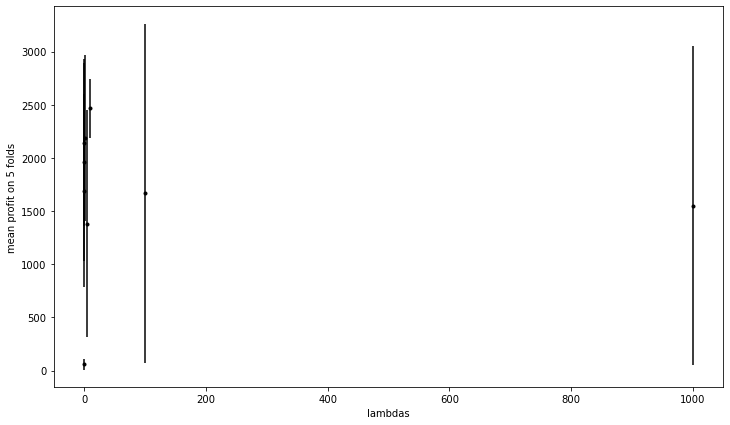

In [364]:
C_list = [0.0001, 0.001, 0.01, 0.1, 1, 5, 10, 100, 1000]

results = {}

for C in C_list:
    preds, y_trues = cal_cv(X_train_splits, X_test_splits, y_train_splits, y_test_splits, X_transformed, y, C)
    _, mean_profit, _, std_profit = calc_profit(preds, y_trues)
    results[C] = [mean_profit, std_profit]
    
results = pd.DataFrame(results).T.rename(columns={0:'profit', 1:'std'})
    
plt.figure(figsize=(12, 7))
plt.errorbar(x=results.index, y=results['profit'], yerr=results['std'], fmt='.k')
plt.xlabel('lambdas')
plt.ylabel('mean profit on 5 folds');

print(f'max profit = {results.profit.max()}')
print(f'best lambda = {results.profit.idxmax()}')

Попробуйте запустить перебор несколько раз. Находится ли каждый раз один и тот же "лучший" коэффициент? Присутствует ли какая-то закономерность? Какие вы можете сделать из этого выводы?

Если оставлять размер вклада, как случаную величину, то каждый раз оптимальный коффициент регуляризации менятся с точки зрения максимальной прибыли. Стоит отметить, что стандартные отклонения у всех значений прибыли очень высокие, поэтому, если бы мы строили доверительные интервалы, то вряд ли бы доказали статистическую разницу между полученными значениями. Поэтому в данном случае регуляризация особо не помогает, хотя максимальная прибыль почти всегда больше, чем полученная в самом начале при заданном значении вклада. 

#### __Задание 13. Ключевая метрика__ (1 балл)

Выше мы уже описали примерную экономическую модель вашей задачи. Как вы считаете, что для вашего бизнеса важнее — хороший precision или recall модели? Почему?

__Ответ:__ Для нашей модели важнее recall, потому что нам не так страшно позвонить большому количеству людей, которые не сделают депозит, зато мы потеряем от того, если пропустим людей готовых сделать вложение. Поэтому нам важно покрывать положительный класс, то есть максимизировать recall, при этом мы можем себе позволить терять в precision.



> Вспомним, что на самом деле логистическая регрессия предсказывает нам вероятности положительного класса для объекта. Возможно, путем настройки __порога бинаризации__ этих вероятностей мы сможем получить какой-то выигрыш?

Проверьте ваши рассуждения выше с помощью настройки порога бинаризации на кросс-валидации для максимизации прибыли. Воспользуйтесь сеткой от 0 до 1 с шагом 0.01. Напомним, что снижение порога дает нам более высокий recall и более низкий precision, и наоборот.

In [374]:
from sklearn.metrics import precision_score, recall_score

def cal_cv_with_thresholds(X_train_splits, X_test_splits, y_train_splits, y_test_splits, X, y, threshold):

    preds = []
    y_trues = []
    recalls = []
    precisions = []

    for X_train_split, X_test_split, y_train_split, y_test_split in zip(X_train_splits, X_test_splits, y_train_splits, y_test_splits):
        logreg = LogisticRegression(random_state=1)
        logreg.fit(X[X_train_split], y[y_train_split])
        y_pred = logreg.predict_proba(X[X_test_split])[:, 1] > threshold
        preds.append(y_pred)
        y_true = y[y_test_split]
        y_trues.append(y_true)
        recalls.append(recall_score(y_true, y_pred))
        precisions.append(precision_score(y_true, y_pred))
        
    return preds, y_trues, recalls, precisions

max profit = 6759.199572226545
best threshold = 0.09
recall when profit is max: 0.6775109344009133, std: 0.016823408690650354
precision when profit is max: 0.29331842081793, std: 0.010783435093767432


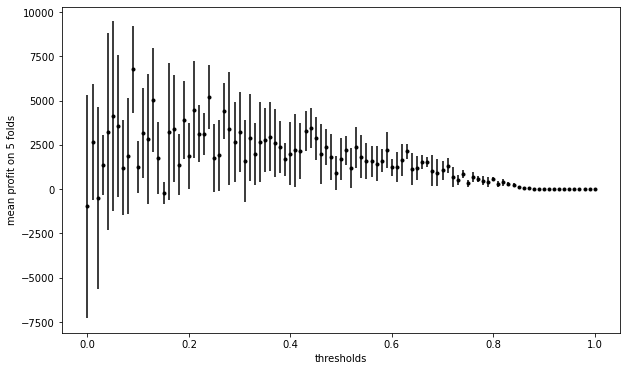

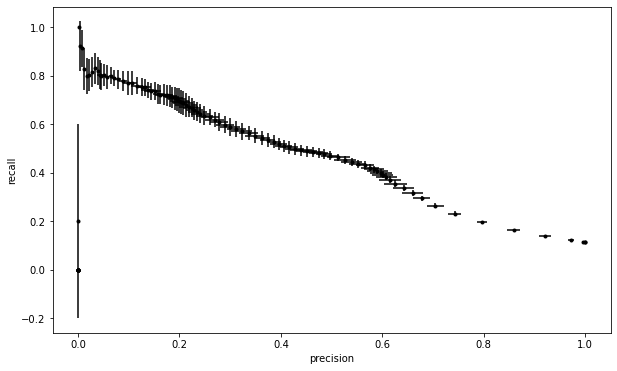

In [391]:
thresholds = np.arange(0, 1.01, 0.01)

results = {}

for threshold in thresholds:
    preds, y_trues, recalls, precisions = cal_cv_with_thresholds(X_train_splits, X_test_splits, y_train_splits, y_test_splits, X_transformed, y, threshold)
    _, mean_profit, _, std_profit = calc_profit(preds, y_trues)
    mean_precision = np.mean(precisions)
    std_precision = np.std(precisions)
    mean_recall = np.mean(recalls)
    std_recall = np.std(recalls)
    results[threshold] = [mean_profit, std_profit, mean_precision, std_precision, mean_recall, std_recall]
    
results = pd.DataFrame(results).T.rename(columns={0:'profit', 1:'std', 2:'precision', 3:'std_precision', 
                                                 4:'recall', 5:'std_recall'})

plt.figure(figsize=(10, 6))
plt.errorbar(x=results.index, y=results['profit'], yerr=results['std'], fmt='.k')
plt.xlabel('thresholds')
plt.ylabel('mean profit on 5 folds')

best_recall = results[results.profit == results.profit.max()].recall.values[0]
std_best_recall = results[results.profit == results.profit.max()].std_recall.values[0]
best_precision = results[results.profit == results.profit.max()].precision.values[0]
std_best_precision = results[results.profit == results.profit.max()].std_precision.values[0]

print(f'max profit = {results.profit.max()}')
print(f'best threshold = {results.profit.idxmax()}')
print(f'recall when profit is max: {best_recall}, std: {std_best_recall}')
print(f'precision when profit is max: {best_precision}, std: {std_best_precision}')

plt.figure(figsize=(10, 6))
plt.errorbar(x=results['recall'], y=results['precision'], xerr=results['std_recall'], 
             yerr=results['std_precision'], fmt='.k')
plt.xlabel('precision')
plt.ylabel('recall');

Постройте график зависимости прибыли от порога бинаризации, также отметьте на нем стандартные отклонения. Выделите наилучший порог.




__Вопрос:__ Замечаете ли вы какую-то закономерность? Для правильного ответа на этот вопрос попробуйте запустить несколько раз и задумайтесь, почему порог получается в какой-то конкретной области?

__Ответ:__ Максимальная прибыль достигается на участке, где порога бинаризации достаточно мал, но не слишком. При слишком маленьком пороге, мы можем уходить даже в минус, потому что будет очень много неуспешных звонков. Поэтому, в основном, оптимальный порог бинаризации лежит в райне 0,1-0,3. В конце, когда порог приближается к 1 и recall становиться очень маленьким, а precision очень высоким, наблюдается стремление прибыли к 0. Мы делаем очень мало звонков, они скорее всего принесут нам прибыль, но из-за того что звонков мало, прибыль очень маленькая. Это напрямую следует из постановки нашей задачи, когда мы сказали, что для нас важнее recall, чем precision, однако, как мы видим, очень уж маленький порог бинаризации может быть плох. 

Каковы значения precision и recall на выбранном пороге? Оцените по кросс-валидации. Также вычислите стандартное отклонение.

In [392]:
print(f'recall when profit is max: {best_recall}, std: {std_best_recall}')
print(f'precision when profit is max: {best_precision}, std: {std_best_precision}')

recall when profit is max: 0.6775109344009133, std: 0.016823408690650354
precision when profit is max: 0.29331842081793, std: 0.010783435093767432


Можно пронаблюдать, что наша модель склоняется к более высокому recall. Попробуйте оценить качество модели с помощью `PR-AUC` в зоне recall $\geq$ 0.5. Сделайте это следующим образом:
- выберите только те пороги, на которых достигается необходимый recall,
- затем интерпретируйте отсеченный в единичном квадрате прямоугольник как новый единичный квадрат,
- посчитайте площадь под отсеченной кривой

AUC-PR = 0.12266333122013963


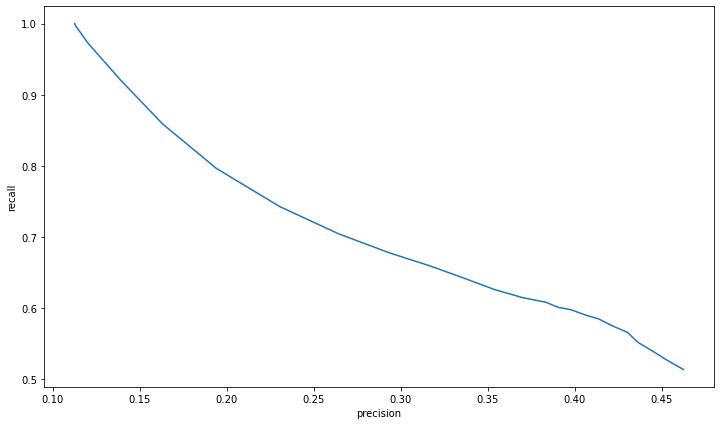

In [397]:
bigrecalls = results[results.recall >= 0.5]
auc_pr = auc(bigrecalls.recall, bigrecalls.precision)
print(f'AUC-PR = {auc_pr}')
plt.figure(figsize=(12, 7))
sns.lineplot(y=bigrecalls.recall, x=bigrecalls.precision);

__Бонус (0.01 балла):__ что вы кушали в день сдачи данного ДЗ на завтрак?

__Ответ:__ Кашу с ягодами